In [1]:
require(data.table)

#HGMD mutations are currently filtered to the 138 mutations with strongest impact
#due to licensing retrictions. We will update this if we obtain proper agreement to 
#release full data

anno = fread('./sei_data/hgmd_above1.1_anno.tsv')
refproj = fread('./sei_data/hgmd_above1.1_refproj.tsv')
altproj = fread('./sei_data/hgmd_above1.1_altproj.tsv')

reflouvain = fread('./sei_data/hgmd_above1.1_seqclass_refanno.tsv')
cnames = fread('../resources/cnames.tsv')

Loading required package: data.table


In [2]:
anno$C_reflouvain= as.numeric(reflouvain$V4)
anno$C_diff = apply(abs(data.matrix(altproj-refproj)),1,which.max)-1
anno$diff_C_diff = data.matrix((altproj-refproj))[cbind(1:dim(refproj)[1],anno$C_diff+1)]
anno$diff_C_reflouvain = data.matrix((altproj-refproj))[cbind(1:dim(refproj)[1],anno$C_reflouvain+1)]

#mutation sequence class assignment
anno$C_final = anno$C_reflouvain
anno$diff_C_final = anno$diff_C_reflouvain
ind = which( (abs(anno$diff_C_diff) > abs(anno$diff_C_reflouvain) + 1) &(abs(anno$diff_C_diff) > 2.5*abs(anno$diff_C_reflouvain) ) )
anno$C_final[ind] = anno$C_diff[ind]
anno$diff_C_final[ind] = anno$diff_C_diff[ind]


Loading required package: ggrepel
Loading required package: ggplot2
Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”

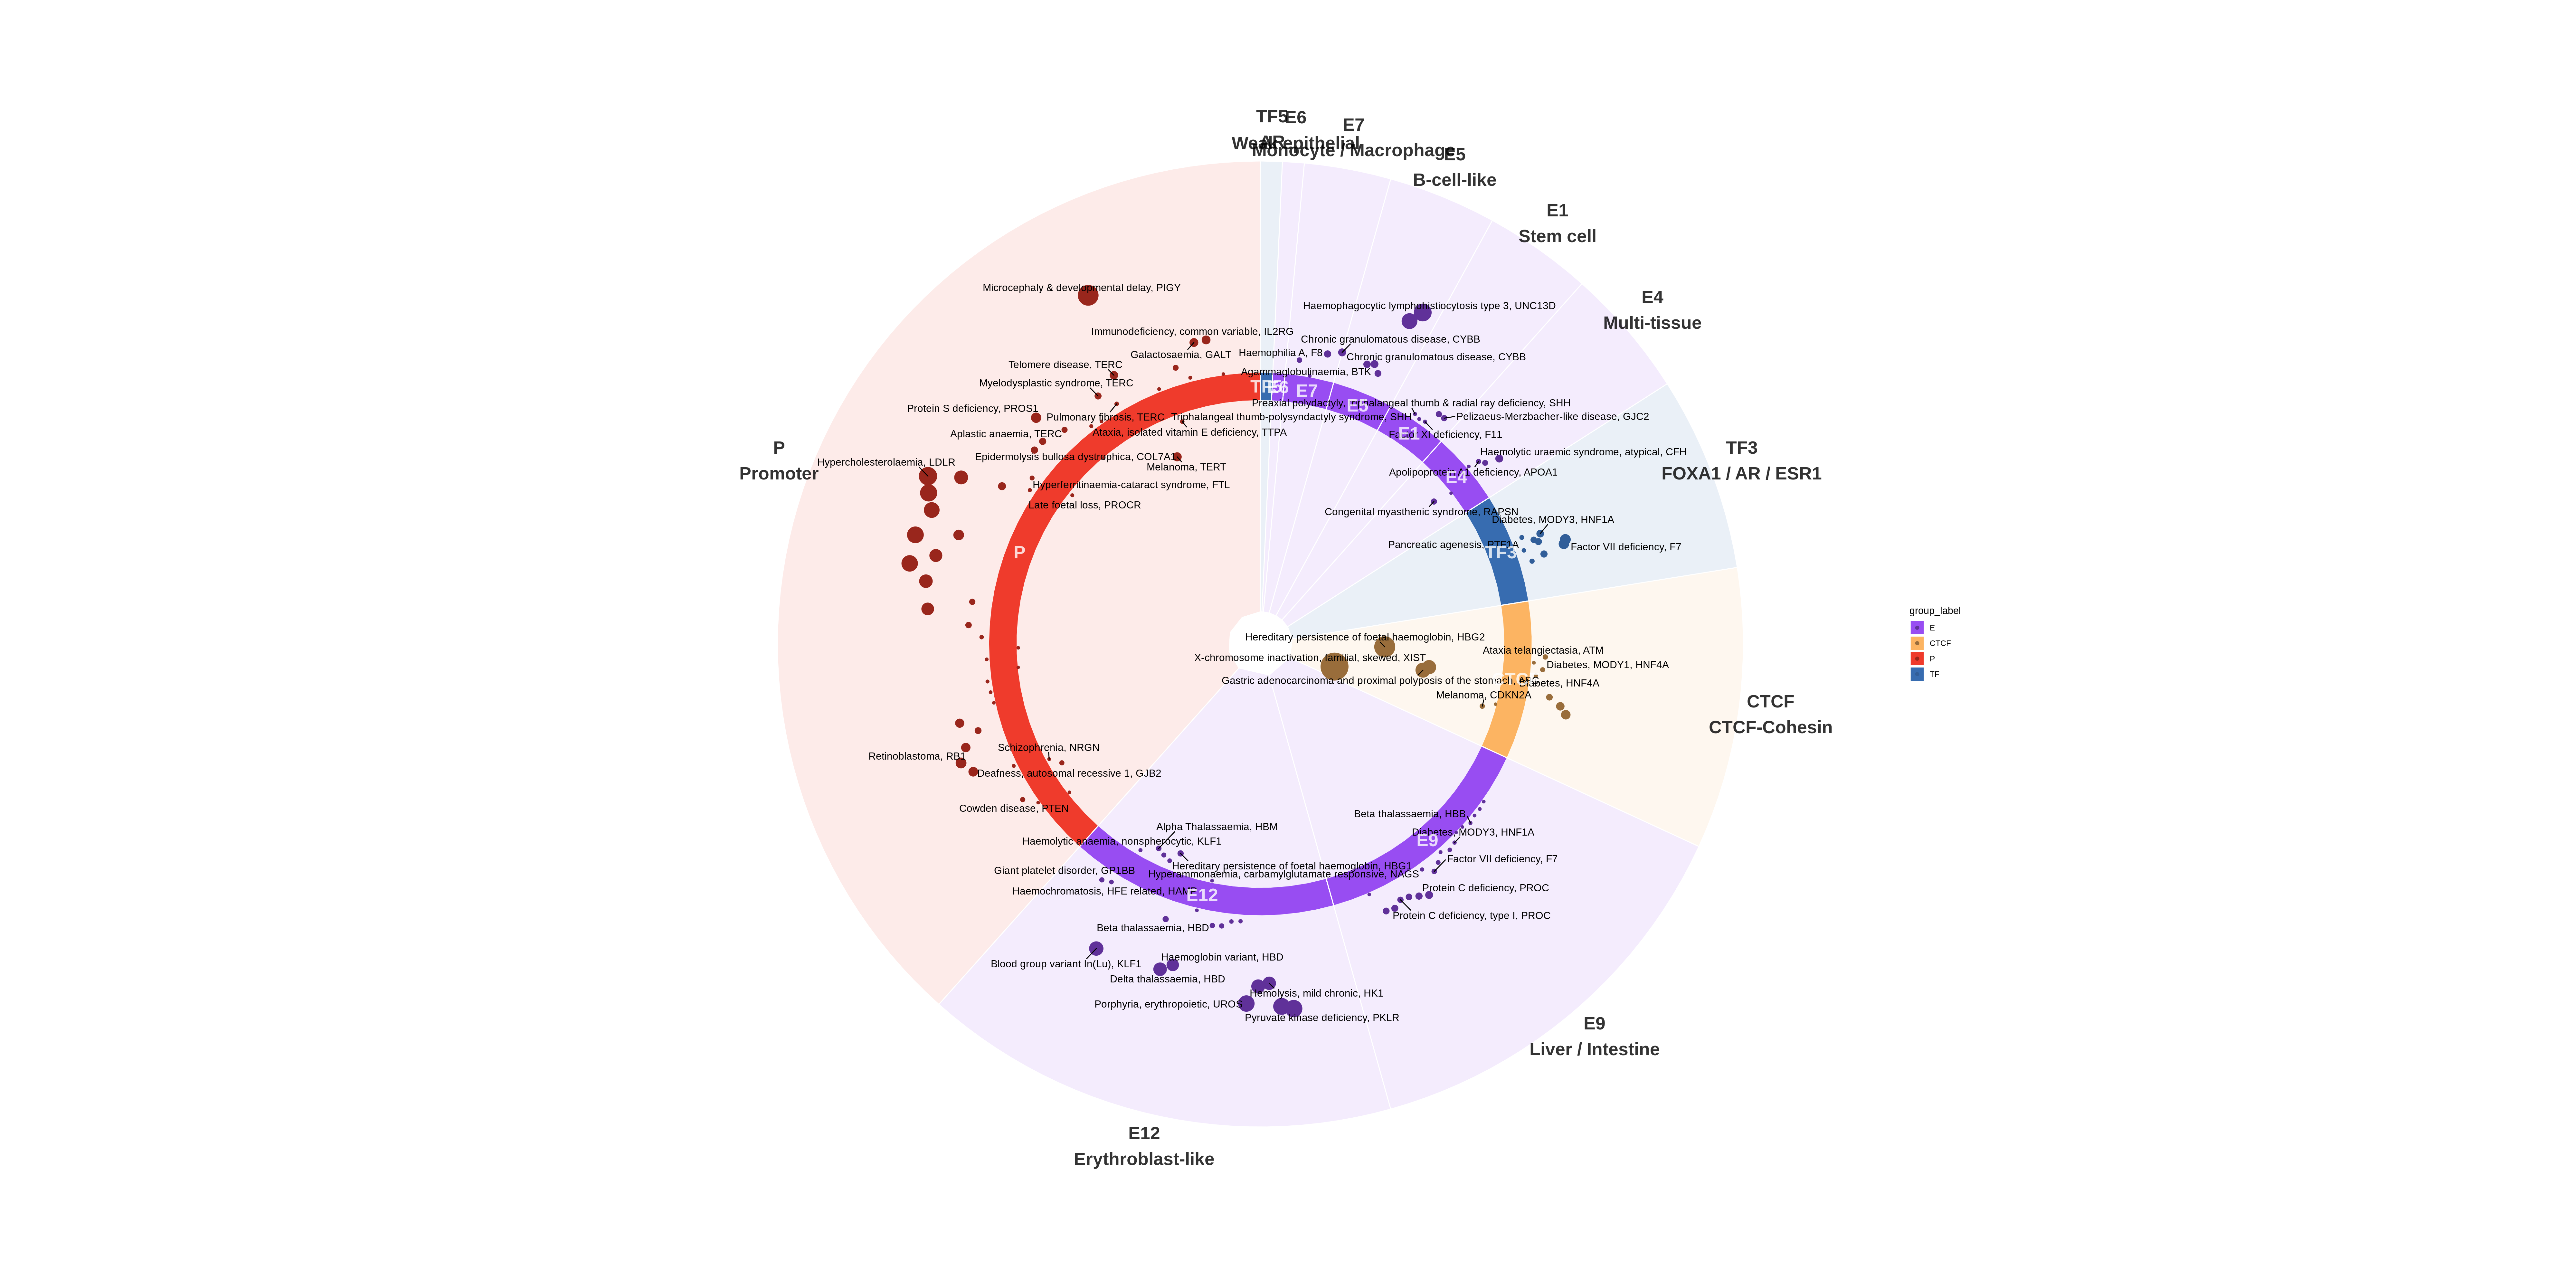

In [3]:
#This partially reproduces Figure 4 including only mutations with sequence class-level variant effect score > 1.1

options(repr.plot.width = 40, repr.plot.height = 20, repr.plot.res = 200)
library(shades)
require(ggrepel)


plotdata_group=data.frame(sort(table(anno$C_final),decreasing = T))
colnames(plotdata_group)[1] = 'index'

#order the variants
plotdata = anno
plotdata$cind =  -match(plotdata$C_final, plotdata_group$index)
plotdata = plotdata[order(cind, chr, pos)]
plotdata$ind=1:dim(plotdata)[1]

#make disease label appear only once if multiple mutations share the same for the same cluster
plotdata$pheno_filtered=""
plotdata[,max_C_final := max(abs(diff_C_final)),by=list(pheno,C_final)]
plotdata[abs(diff_C_final)==max_C_final, pheno_filtered:=paste(pheno,gene,sep=', ')]

plotdata_group=data.table(plotdata_group)
plotdata_group$label = cnames$ID[match(plotdata_group$index, cnames$index)]
plotdata_group$names = cnames$name[match(plotdata_group$index, cnames$index)]
plotdata_group$group_label = cnames$group[match(plotdata_group$index, cnames$index)]
plotdata_group$group_label = factor(plotdata_group$group_label,levels=c('E','CTCF','P','TF','HET','PC','TN','L'))

plotdata$group_label = plotdata_group$group_label[match(plotdata$C_final, plotdata_group$index)]
plotdata$label = plotdata_group$label[match(plotdata$C_final, plotdata_group$index)]
plotdata$names = plotdata_group$names[match(plotdata$C_final, plotdata_group$index)]



shift=3
plotdata[cind > -15, newind:=(ind-min(ind))/(max(ind)-min(ind))*(max(ind)-min(ind)-shift*2)+min(ind)+shift ,by=cind]
plotdata[cind <= -15, newind:=as.double(ind)]

scale_fill_Publication <- function(...){
      library(scales)
      #discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#984ea3","#662506","#a6cee3","#fb9a99","#dddddd")), ...)
      discrete_scale("fill","Publication",manual_pal(values = c("#984ef3","#fdb462","#ef3b2c","#386cb0","#662506","#a6cee3","#fb9a99","#dddddd")), ...)


}
scale_color_Publication <- function(...){
      library(scales)
      #discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#984ea3","#662506","#a6cee3","#fb9a99","#dddddd")), ...)
      discrete_scale("color","Publication",manual_pal(values = brightness(c("#984ef3","#fdb462","#ef3b2c","#386cb0","#662506","#a6cee3","#fb9a99","#dddddd"),0.6)), ...)
}




ggplot() +
  geom_bar(aes(x = 0, y = Freq, group = index, fill=group_label),width=2.2,stat = "identity", color = "white",data=plotdata_group) +
  geom_bar(aes(x = 0, y = Freq, group = index, fill=group_label),width=35, alpha=I(0.1),stat = "identity", color = "white",data=plotdata_group) +
  coord_polar(theta = "y", start = 0)+
  theme_void()+
  xlim(-20, 20)+
geom_point(aes(y=newind, x=-diff_C_final,color=group_label,size=I(abs(diff_C_final))), data=plotdata[abs(diff_C_final)>0.,])+
geom_text_repel(aes(y=newind, x=-(diff_C_final),label=pheno_filtered), nudge_x = -0.3, data=plotdata[diff_C_final>1.3,],size=4.,force=6)+
geom_text_repel(aes(y=newind, x=-(diff_C_final),label=pheno_filtered), nudge_x = 0.3, data=plotdata[diff_C_final< -1.3,],size=4.,force=6)+
geom_text(aes(x = 0, y = rev(cumsum(rev(Freq)))-Freq/2, label = label), size=7, alpha=0.8, color = "white", fontface = "bold", data=plotdata_group)+
geom_text(aes(x = 20, y = rev(cumsum(rev(Freq)))-Freq/2, label = paste0(label,'\n',names)), size=7, alpha=0.8, color = "black", fontface = "bold", data=plotdata_group)+
scale_fill_Publication()+scale_color_Publication()



ggsave('./figures/hgmd.seqclass.effects.pdf', width=40, height = 20, dpi = 200, device=cairo_pdf)




In [4]:
output_table = plotdata[abs(plotdata$diff_C_final)>1.1, c("chr","pos","ref","alt","gene","pheno","label","names","diff_C_final"),with=F]
colnames(output_table)<-c("Chr","Pos","REF","ALT","gene","phenotype","Sequence class label","Sequence class name",
                          "Sequence class-level variant effect")
write.csv(output_table, 
            './sei_data/hgmd.highpredictions.raw.csv')



Loading required package: plyr


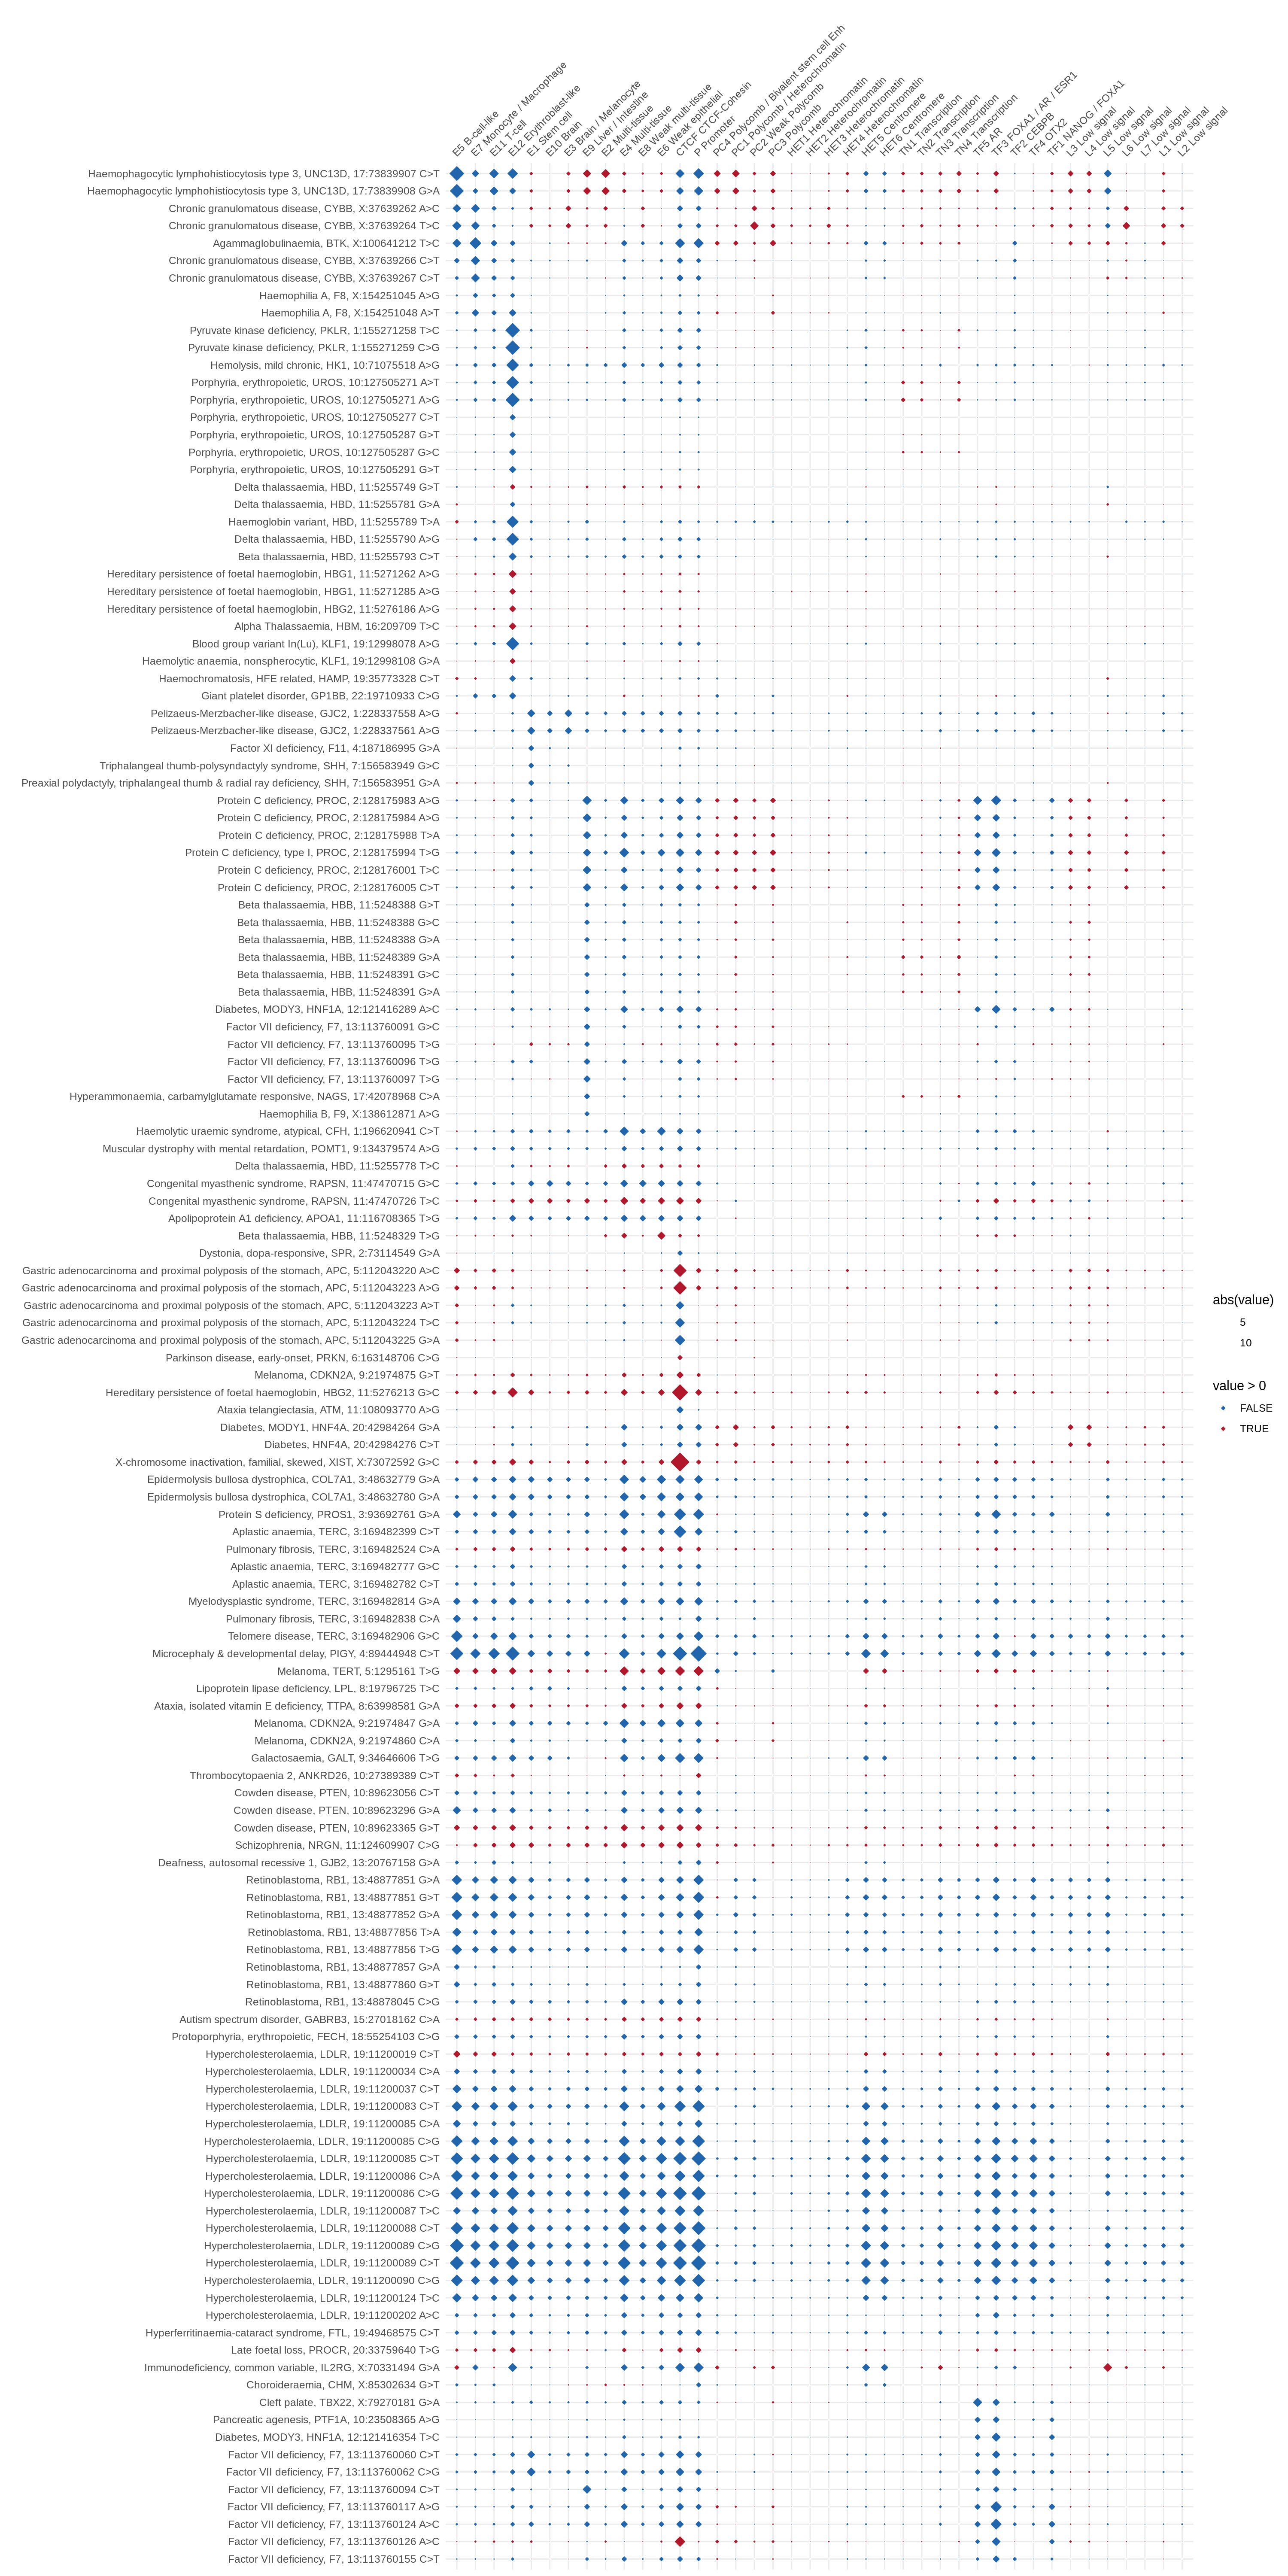

In [5]:
require(plyr)
selectinds = abs(anno$diff_C_final)>1.1 
plotdiffs =  altproj[selectinds,1:40]-refproj[selectinds,1:40]
colnames(plotdiffs) = as.character(0:39)
anno[,id:=paste(pheno,gene, paste0(chr,':',pos,' ',ref,'>',alt),sep=', '),]
plotdiffs$id = anno[selectinds, id]

plotdata = melt(plotdiffs, id='id')
plotdata = rename(plotdata, c("variable" = "C"))
plotdata$C = as.numeric(as.matrix(plotdata$C))
cnames$label_name = paste(cnames$ID, cnames$name)


options(repr.plot.width = 15, repr.plot.height = 30, repr.plot.res = 200)
plotdata$C = factor( cnames$label_name[match(plotdata$C,cnames$index)], levels=cnames$label_name)
plotdata$id = factor(plotdata$id, levels=plotdiffs$id[rev(order(match(anno$C_final[selectinds], cnames$index)))])
ggplot(plotdata)+geom_point(aes(x=C,y=id, size=abs(value),fill=value>0),color='white',shape=23)+scale_fill_manual(values=c('#2166ac','#b2182b'))+
    theme_minimal()+ scale_size_area()+xlab('')+ylab('')+
    theme(axis.text.x = element_text(angle = 45, vjust = 0, hjust=0))+scale_x_discrete(position = c("top")) #
ggsave('./figures/hgmd.highpredictions.matrix.pdf',  width=15, height = 30, dpi = 200, device=cairo_pdf)